In [7]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for DB
from sqlalchemy import create_engine

from scipy import stats

In [8]:
# Connection DB
engine = create_engine("mysql+pymysql://root@localhost/world")

In [ ]:
# 1. Measure of Central Tendency (Ukuran pemusatan)

query = "SELECT * FROM city"
df = pd.read_sql(query, engine)

mean_pop = df["Population"].mean()
median_pop = df["Population"].median()
mode_pop = df["Population"].mode()[0]

print("mean:", mean_pop)
print("median:", median_pop)
print("mode:", mode_pop)

# Mean = rata-rata populasi kota
# Median = nilai tengah (lebih tahan terhadap outlier)
# Mode = nilai yang paling sering muncul

mean: 350468.22358421184
median: 167051.0
mode: 90000


In [ ]:
# 2. Measure of Dispersion (Ukuran penyebaran)

range_pop = df["Population"].max() - df["Population"].min()
var_pop = df["Population"].var()
std_pop = df["Population"].std()

print("Range:", range_pop)
print("Variance:", var_pop)
print("Standard Deviation:", std_pop)

#Range = selisih populasi kota terbesar & terkecil
#Variance = seberapa jauh data menyebar dari rata-rata
#Std Dev = akar variance, ukuran penyebaran yang lebih mudah dibaca

Range: 10499958
Variance: 523851281577.4655
Standard Deviation: 723775.712204731


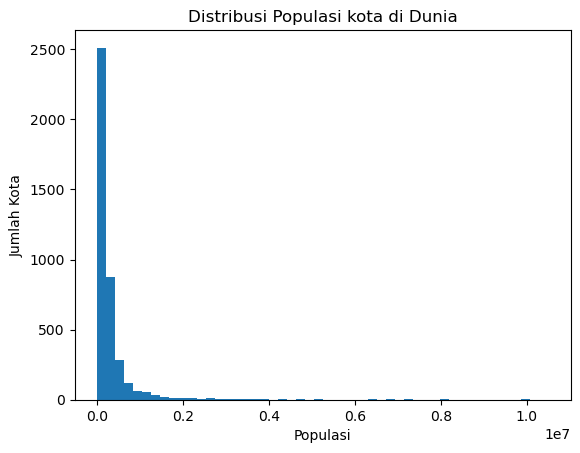

In [7]:
# Distribusi data (histogram)

plt.hist(df["Population"], bins=50)
plt.title("Distribusi Populasi kota di Dunia")
plt.xlabel("Populasi")
plt.ylabel("Jumlah Kota")
plt.show()

In [8]:
# Korelasi (Hubungan Antar Variabel) Misalnya kita cek hubungan Luas Negara vs Populasi Negara

query = "SELECT Name, SurfaceArea, Population FROM country"
df_country = pd.read_sql(query, engine)

corr = df_country["SurfaceArea"].corr(df_country["Population"])
print("Korelasi Luas vs Populasi:", corr)

Korelasi Luas vs Populasi: 0.42398978630087614


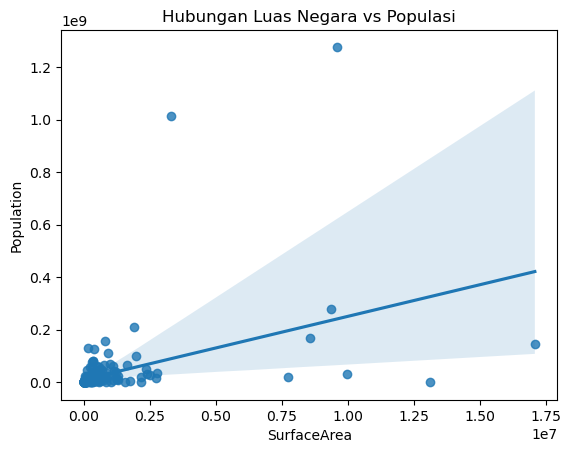

In [9]:
# Regresi Linear Sederhana (Garis Tren) Misalnya: prediksi populasi negara berdasarkan luas wilayah.

sns.regplot(x="SurfaceArea", y="Population", data=df_country)
plt.title("Hubungan Luas Negara vs Populasi")
plt.show()

1) Welch’s t-test: Asia vs Europe (rata-rata populasi KOTA)

In [11]:
# Ambil data populasi kota + benua

query = """ 
SELECT city.Population AS city_pop, country.Continent AS continent
FROM city 
JOIN country ON city.CountryCode = country.Code
WHERE country.Continent IN ('Asia', 'Europe')
"""

df = pd.read_sql(query, engine)

asia = df.loc[df["continent"]=="Asia", "city_pop"]
europe = df.loc[df["continent"]=="Europe", "city_pop"]

# Opsional cek cepat ringkasan
print(df.groupby("continent",)["city_pop"].describe())

# Welch’s t-test (equal_var=False)
t_stat, p_val = stats.ttest_ind(asia, europe, equal_var=False)

# Efek: Cohen's d (versi Welch: gunakan pooled std berbobot)
def cohens_d(a, b):
    na, nb = len(a), len(b)
    sa2, sb2 = np.var(a, ddof=1), np.var(b, ddof=1)
    s_pooled = np.sqrt(((na-1)*sa2 + (nb-1)*sb2 / (na+nb-2)))
    return (np.mean(a) - np.mean(b)) / s_pooled

d = cohens_d(asia, europe)

print(f"Welch t-stat = {t_stat:.3f}, p-value = {p_val:.6f}")
print(f"Cohen's d = {d:.3f}")

            count           mean            std      min       25%       50%  \
continent                                                                      
Asia       1766.0  395019.310872  854407.800557  21484.0  119734.5  172260.0   
Europe      841.0  287684.676576  512049.769463    455.0  110214.0  158158.0   

                 75%         max  
continent                         
Asia       322087.75  10500000.0  
Europe     283670.00   8389200.0  
Welch t-stat = 3.986, p-value = 0.000069
Cohen's d = 0.003


2) >2 Kelompok: ANOVA vs Kruskal–Wallis (antar benua)

In [12]:
query = """ 
SELECT city.Population AS city_pop, country.Continent AS continent
FROM city
JOIN country ON city.CountryCode = country.Code
WHERE country.Continent IN ('Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania')
"""

dfk = pd.read_sql(query, engine)

groups = [g["city_pop"].values for _, g in dfk.groupby("continent")]
f_stat, p_f = stats.f_oneway(*groups)

print(f"ANOVA F = {f_stat:.3f}, p-value = {p_f:.6f}")

ANOVA F = 3.743, p-value = 0.002203


3) Chi-Square Test of Independence: Resmi/Tidak Resmi vs Benua

In [13]:
# Ambil data bahasa (countrylanguage) dan benua
query = """
SELECT country.Continent AS continent, countrylanguage.IsOfficial AS is_official
FROM countrylanguage
JOIN country ON countrylanguage.CountryCode = country.Code
WHERE country.Continent IN ('Asia','Europe','Africa','North America','South America','Oceania');
"""
dfl = pd.read_sql(query, engine)

# Buat kontingensi: count Official vs Not per benua
contingency = pd.crosstab(dfl["is_official"], dfl["continent"])
print(contingency)

chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi-square = {chi2:.3f}, dof = {dof}, p-value = {p_chi:.6f}")

continent    Africa  Asia  Europe  North America  Oceania  South America
is_official                                                             
F               272   182     143             74       49             26
T                38    57      59             35       33             16
Chi-square = 46.541, dof = 5, p-value = 0.000000


C:\Users\ACER Aspire 3\AppData\Local\Temp\ipykernel_13800\144900762.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="continent", y="city_pop", data=df, palette="Set2")


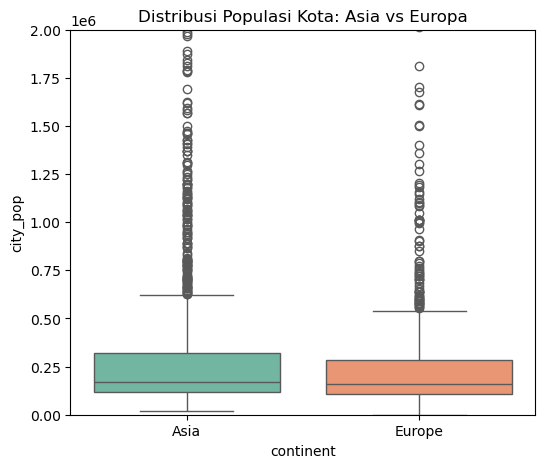

In [15]:
# 1. Welch’s t-test (Asia vs Eropa) 

plt.figure(figsize=(6,5))
sns.boxplot(x="continent", y="city_pop", data=df, palette="Set2")
plt.ylim(0, 2000000) # batasi agar tidak ketarik kota super besar
plt.title("Distribusi Populasi Kota: Asia vs Europa")
plt.show()

C:\Users\ACER Aspire 3\AppData\Local\Temp\ipykernel_13800\2633323563.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="continent", y="city_pop", data=dfk, palette="Set3")


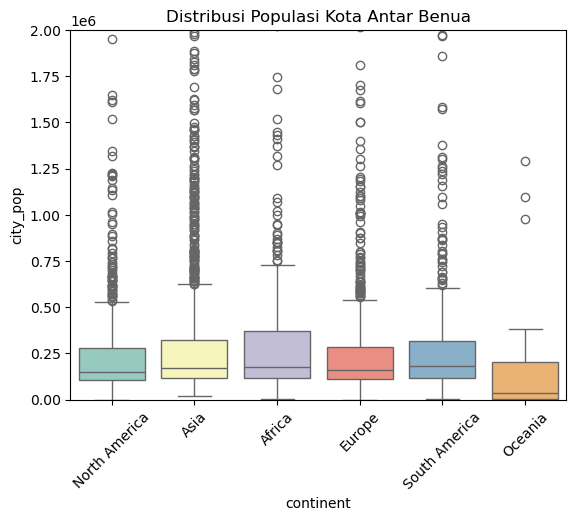

In [16]:
# 2. ANOVA antar benua (Pakai boxplot semua benua sekaligus.)

plt.Figure(figsize=(10,6))
sns.boxplot(x="continent", y="city_pop", data=dfk, palette="Set3")
plt.ylim(0, 2000000)
plt.title("Distribusi Populasi Kota Antar Benua")
plt.xticks(rotation=45)
plt.show()

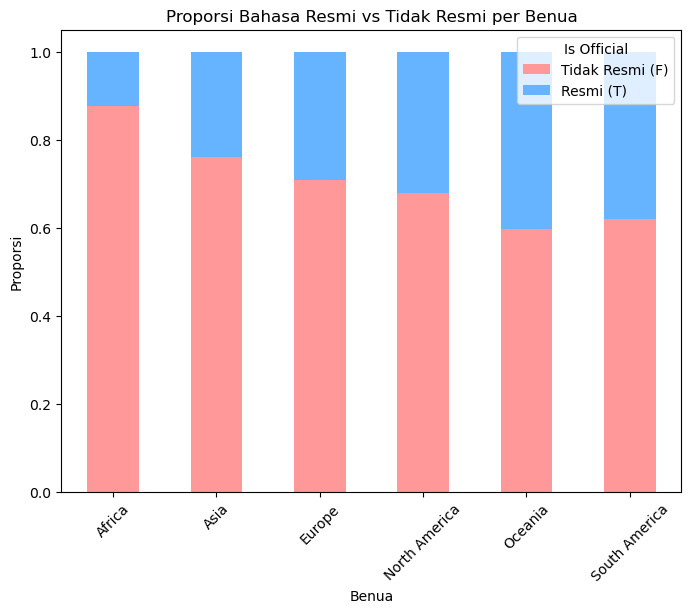

In [17]:
# 3. Chi-Square (Bahasa Resmi vs Tidak Resmi per Benua) Bisa pakai stacked bar chart untuk proporsi resmi vs tidak resmi.

contingency_norm = contingency.div(contingency.sum(axis=0), axis=1).T

contingency_norm.plot(
    kind="bar", stacked=True, figsize=(8,6), color=["#ff9999","#66b3ff"]
)

plt.title("Proporsi Bahasa Resmi vs Tidak Resmi per Benua")
plt.ylabel("Proporsi")
plt.xlabel("Benua")
plt.legend(title="Is Official", labels=["Tidak Resmi (F)", "Resmi (T)"])
plt.xticks(rotation=45)
plt.show()